In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = '326372',
                             database = 'ecommerce')
cur = db.cursor()


### 1. List all unique cities where customers are located.

In [2]:
query = '''select distinct customer_city from customers'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [3]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

### 3. Find the total sales per category.


In [4]:
query = '''select upper(products.product_category) as category,
round(sum(payments.payment_value),2) as sales
from products join order_item
on products.product_id = order_item.product_id
join payments
on payments.order_id = order_item.order_id
group by category'''
cur.execute(query)
data = cur.fetchall()
df  = pd.DataFrame(data, columns = ['category','sales'])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = '''select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments'''
cur.execute(query)
data = cur.fetchall()
'The percentage of orders that were paid in installments',data[0][0]

('The percentage of orders that were paid in installments', Decimal('99.9981'))

### 5. Count the number of customers from each state.

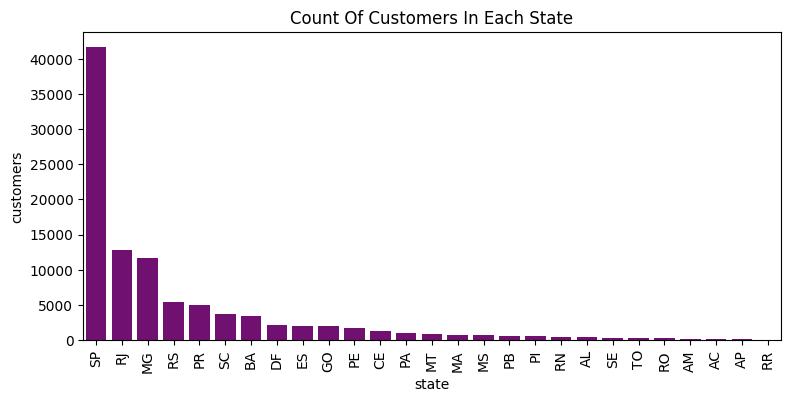

In [6]:
query = '''Select customer_state, count(customer_id) 
from customers group by customer_state'''
cur.execute(query)
data = cur.fetchall()
data

df  = pd.DataFrame(data, columns = ['state','customers'])
df = df.sort_values(by = 'customers', ascending = False)
plt.figure(figsize = (9,4))
ax = sns.barplot(x = df['state'],y = df['customers'], color = 'purple')
plt.xticks(rotation = 90)

plt.title('Count Of Customers In Each State')
plt.show()

### 6. Calculate the number of orders per month in 2018.

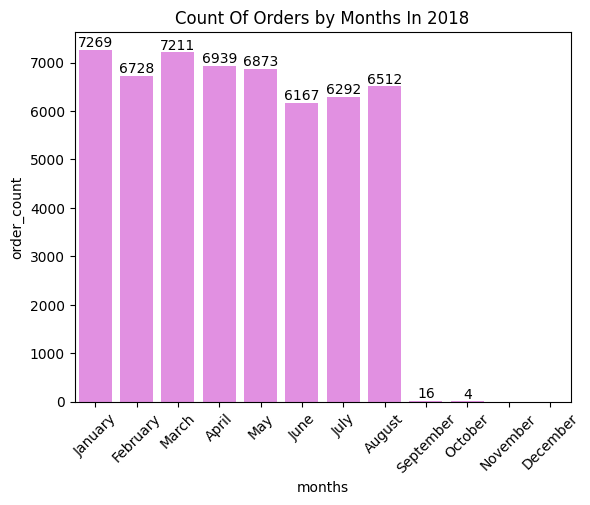

In [7]:
query = '''Select monthname(order_purchase_timestamp) as months,
count(order_id) as order_count
from orders where year(order_purchase_timestamp) = 2018
group by months'''
cur.execute(query)
data = cur.fetchall()

o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df  = pd.DataFrame(data, columns = ['months','order_count'])
ax = sns.barplot(x = df['months'], y = df['order_count'], data = df, order = o, color = 'violet')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])

plt.title('Count Of Orders by Months In 2018')
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [8]:
query = '''with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_item.order_id) as oc
from orders join order_item
on orders.order_id = order_item.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders
;'''
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Customer City','Average Orders'])
df.head(10)

,Customer City,Average Orders
0,sonora,1.00
1,porteiras,1.00
2,itabi,1.00
3,silvanopolis,1.00
4,salmourao,1.00
5,cha de alegria,1.00
6,cerro grande,1.00
7,francisco santos,1.00
8,barras,1.00
9,grupiara,1.00


### 8. Calculate the percentage of total revenue contributed by each product category.


In [9]:
query = '''select upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
from products join order_item
on products.product_id = order_item.product_id
join payments
on payments.order_id = order_item.order_id
group by category order by sales_percentage desc;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Product Category','Average Products/Order'])
df.head()
### Pie chart for 10 product category
### df = df.head(10)
### plt.pie(df['Average Products/Order'], labels = df['Product Category'])
### plt.show()'''

,Product Category,Average Products/Order
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


### 9. Identify thecorrelation between product price and the number of times a product has been purchased.

In [10]:
query = '''select products.product_category, count(order_item.product_id), round(avg(order_item.price),2)
from products join order_item
on products.product_id = order_item.product_id
group by products.product_category;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Product Category','Count Of Order', 'Price'])

arr1 = df['Count Of Order']
arr2 = df['Price']
a = np.corrcoef([arr1,arr2])
print('The correlation between product price and the number of times a product has been purchased',a[0][1])

The correlation between product price and the number of times a product has been purchased -0.10631514167157562


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

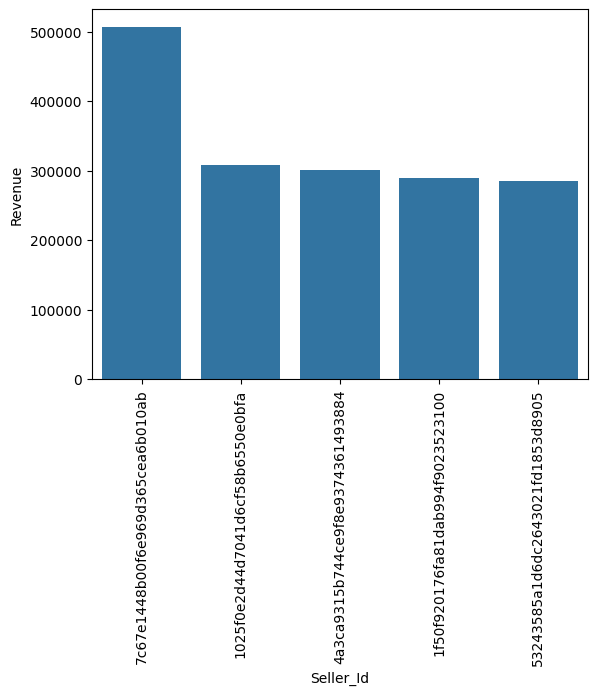

In [11]:
query = '''select *, dense_rank() over(order by revenue desc) as rn from
(select order_item.seller_id, round(sum(payments.payment_value),2) revenue
from order_item join payments
on order_item.order_id = payments.order_id
group by order_item.seller_id) as a'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Seller_Id','Revenue','Rank'])
df = df.head()
sns.barplot(x = 'Seller_Id', y = 'Revenue', data = df)
plt.xticks(rotation = 90)
plt.show()